In [2]:
%pip install pandas

     ---------------------------------------- 11.6/11.6 MB 1.6 MB/s eta 0:00:00
     -------------------------------------- 509.2/509.2 KB 2.3 MB/s eta 0:00:00
     -------------------------------------- 347.8/347.8 KB 1.2 MB/s eta 0:00:00
     ---------------------------------------- 12.9/12.9 MB 2.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'c:\Users\Romain\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [6]:
import os
import glob
import pandas as pd

def aggregate_experiment_results(dataset_name: str, name_filter: str = "scar", val: str = "f1") -> pd.DataFrame:
    """
    Aggregates experiment results from CSV files in the dataset_name's folder.
    If name_filter is provided, only files whose names contain that substring are processed.
    """
    folder_path = rf"C:\Users\Romain\OneDrive - KU Leuven\Github thesis\gnn_pu\gnn_pu\NNIF-GNN\{dataset_name}_experimentations"
    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
    
    # Filter files based on substring in their filename (if name_filter is provided)
    if name_filter:
        csv_files = [f for f in csv_files if name_filter in os.path.basename(f)]
    
    aggregated_results = []
    
    for file in csv_files:
        try:
            df = pd.read_csv(file)
            
            # Check if the dataframe has exactly 5 rows
            if len(df) >= 5:
                aggregated = {}
                for col in df.columns:
                    if pd.api.types.is_numeric_dtype(df[col]):
                        aggregated[col] = df[col].mean()
                    else:
                        mode_val = df[col].mode()
                        aggregated[col] = mode_val.iloc[0] if not mode_val.empty else None
                
                # Specifically add the std of the 'f1' column if it exists
                if 'test_f1' in df.columns:
                    aggregated['f1_std'] = df['test_f1'].std()
                else:
                    aggregated['f1_std'] = None
                    
                aggregated_results.append(aggregated)
        except Exception:
            # Ignore CSVs that cause an error
            pass
    
    aggregated_df = pd.DataFrame(aggregated_results)
    
    # Sort by mean F1 in descending order, if it exists
    if 'f1' in aggregated_df.columns:
        aggregated_df = aggregated_df.sort_values(by=val, ascending=False)
    
    # Save and return the aggregated results
    output_filename = f"{dataset_name}_{name_filter}_aggregated_results.csv"
    aggregated_df.to_csv(output_filename, index=False)
    print(f"Aggregated results saved to {output_filename}")
    return aggregated_df


In [9]:
%pip install matplotlib

     ---------------------------------------- 8.1/8.1 MB 2.3 MB/s eta 0:00:00
     -------------------------------------- 71.9/71.9 KB 978.5 kB/s eta 0:00:00
     ---------------------------------------- 2.7/2.7 MB 2.6 MB/s eta 0:00:00
     ------------------------------------ 221.2/221.2 KB 901.5 kB/s eta 0:00:00
     -------------------------------------- 111.1/111.1 KB 1.3 MB/s eta 0:00:00
     ---------------------------------------- 2.2/2.2 MB 2.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'c:\Users\Romain\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


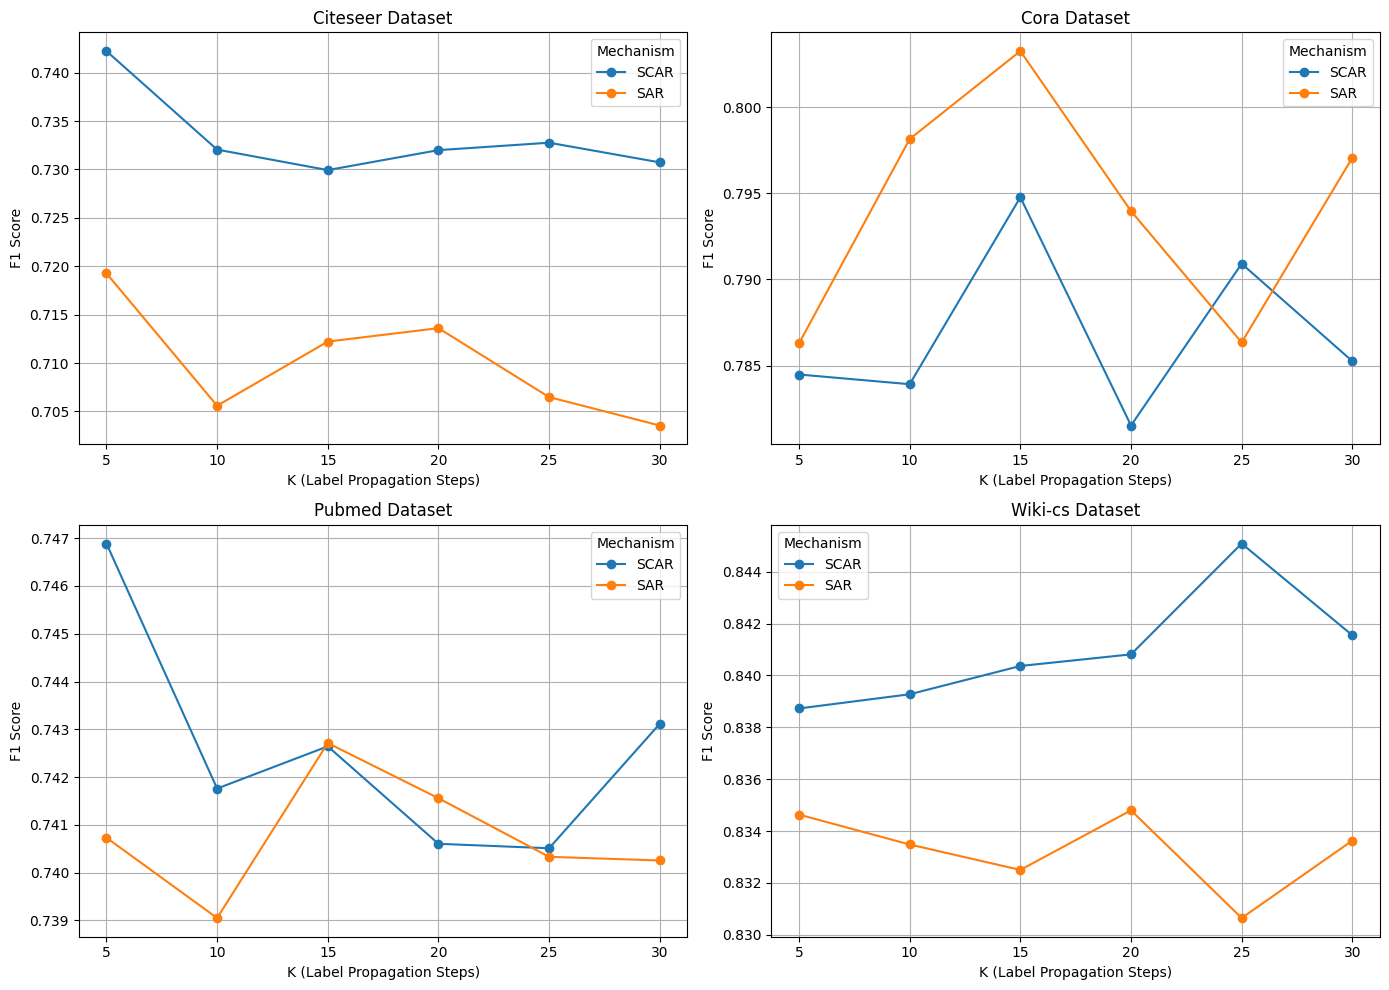

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv(r"C:\Users\Romain\OneDrive - KU Leuven\Github thesis\gnn_pu\gnn_pu\NNIF-GNN\ours_experiments_vary_K_pollution.csv")

df = pd.DataFrame(data)
datasets = df['dataset'].unique()
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for i, dataset in enumerate(datasets):
    ax = axs[i]
    for mechanism in ['SCAR', 'SAR']:
        subset = df[(df['dataset'] == dataset) & (df['mechanism'] == mechanism)].sort_values('K')
        ax.errorbar(subset['K'], subset['avg_f1'],# yerr=subset['std_f1'],
                    label=mechanism, marker='o', capsize=4, linestyle='-')
    ax.set_title(f'{dataset.capitalize()} Dataset')
    ax.set_xlabel('K (Label Propagation Steps)')
    ax.set_ylabel('F1 Score')
    ax.grid(True)
    ax.legend(title='Mechanism')

plt.tight_layout()
plt.savefig(r"C:\Users\Romain\OneDrive - KU Leuven\Github thesis\gnn_pu\gnn_pu\NNIF-GNN\ours_experiments_vary_K_pollution.png")
plt.show()



In [17]:
%pip install seaborn

     -------------------------------------- 294.9/294.9 KB 1.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Romain\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


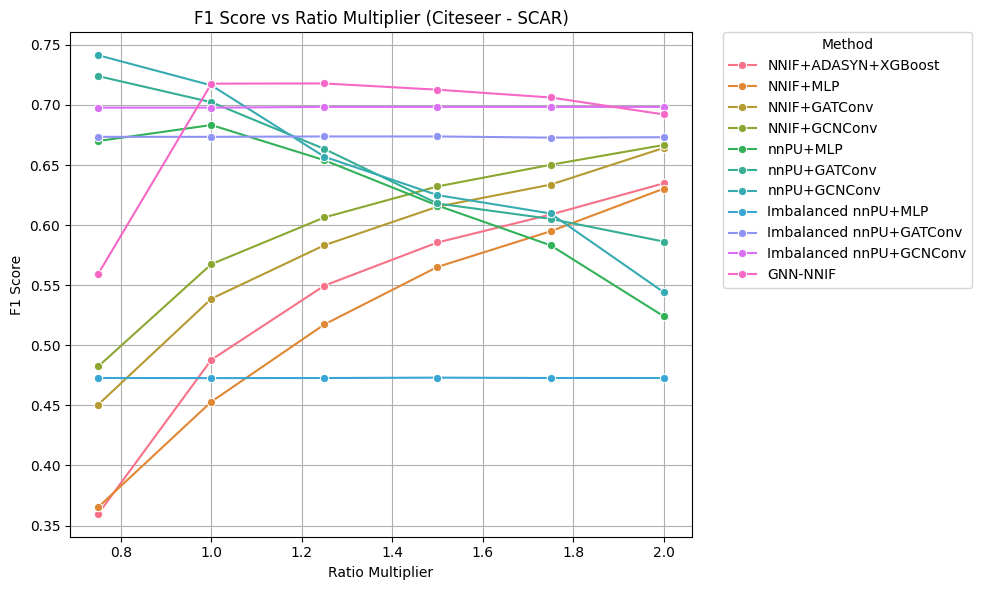

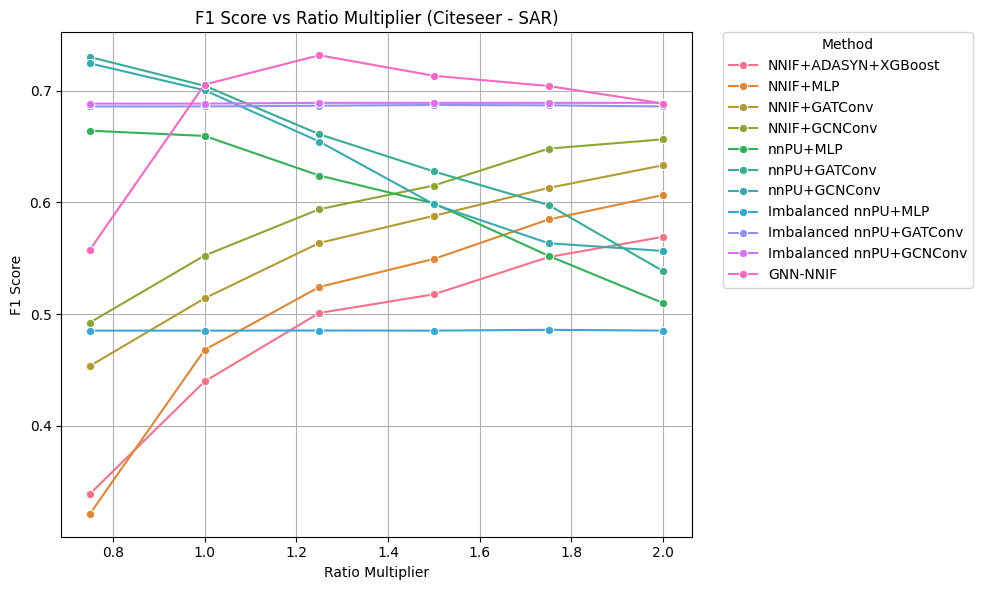

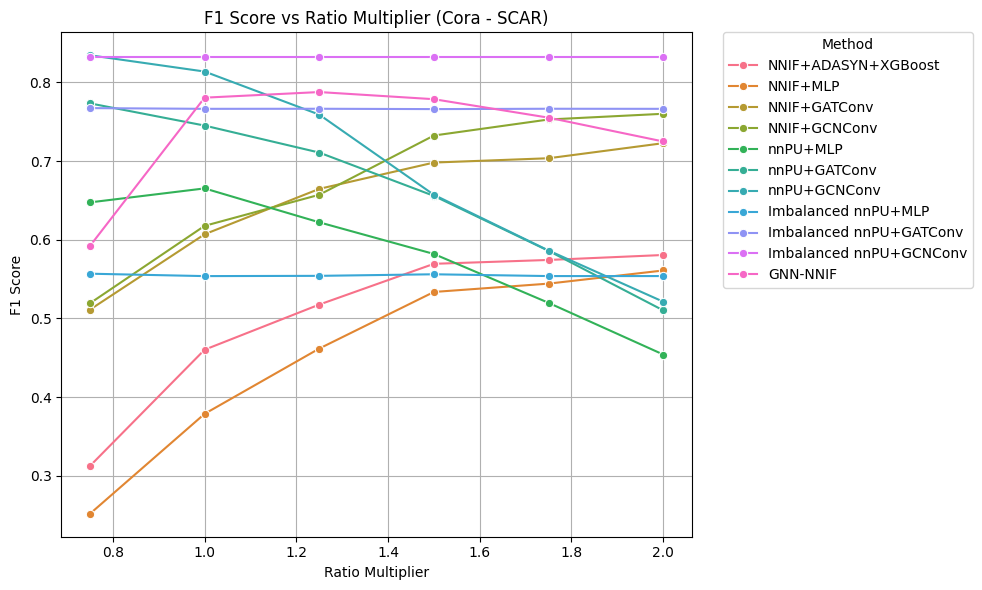

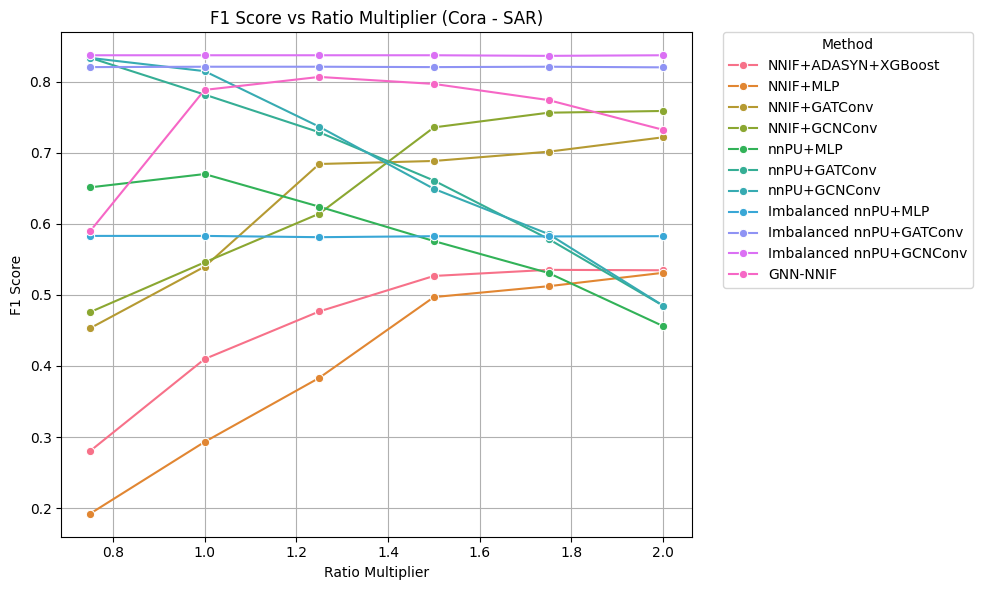

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load CSV data
file_path = r"C:\Users\Romain\OneDrive - KU Leuven\Github thesis\gnn_pu\gnn_pu\NNIF-GNN\varying_prior_pollution_results.csv"
df = pd.read_csv(file_path)

# Generate readable method labels
def format_methodology(row):
    if row['methodology'] == 'NNIF':
        return 'NNIF+ADASYN+XGBoost'
    elif row['methodology'] in ['two_nnif']:
        return f"NNIF+{row['model_type']}"
    elif row['methodology'] in ['nnpu']:
        return f"nnPU+{row['model_type']}"
    elif row['methodology'] in ['imbnnpu']:
        return f"Imbalanced nnPU+{row['model_type']}"
    elif row['methodology'] == 'ours':
        return "GNN-NNIF"
    return row['methodology']

df['method_label'] = df.apply(format_methodology, axis=1)

# Loop over unique (dataset, mechanism) pairs
unique_combinations = df[['dataset', 'mechanism']].drop_duplicates()

for _, row in unique_combinations.iterrows():
    dataset = row['dataset']
    mechanism = row['mechanism']
    
    subset = df[(df['dataset'] == dataset) & (df['mechanism'] == mechanism)]
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=subset,
        x='ratio_multiplier',
        y='avg_f1',
        hue='method_label',
        marker='o'
    )
    plt.title(f"F1 Score vs Ratio Multiplier ({dataset.capitalize()} - {mechanism})")
    plt.xlabel("Ratio Multiplier")
    plt.ylabel("F1 Score")
    plt.legend(
        title="Method",
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        borderaxespad=0.
    )
    plt.savefig(f"C:/Users/Romain/OneDrive - KU Leuven/Github thesis/gnn_pu/gnn_pu/NNIF-GNN/{dataset}_{mechanism}_f1_vs_ratio_multiplier.png", bbox_inches='tight')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [7]:
df=aggregate_experiment_results("cora", "will","test_f1")
#best_rows = df.loc[df.groupby('sampling')['f1'].idxmax()]
df.head(10)
#print(best_rows)

Aggregated results saved to cora_will_aggregated_results.csv


,K,layers,hidden_channels,out_channels,norm,lr,treatment,dropout,ratio,seed,...,accuracy,f1,recall,precision,losses,test_accuracy,test_f1,test_recall,test_precision,f1_std
2,17.0,2.0,256.0,256.0,NaN,0.005,removal,0.0,0.227522,366.6,...,NaN,0.0,0.0,0.0,"[3.313493490219116, 3.163835287094116, 3.44160...",0.934058,0.807578,0.777506,0.840867,0.011510
0,17.0,2.0,256.0,256.0,NaN,0.005,removal,0.0,0.227361,366.6,...,NaN,0.0,0.0,0.0,"[3.31465482711792, 3.164974570274353, 3.442850...",0.933536,0.806207,0.777017,0.838877,0.007429
1,16.0,2.0,256.0,256.0,NaN,0.005,removal,0.0,0.251569,366.6,...,NaN,0.0,0.0,0.0,"[3.0989784002304077, 2.9678701162338257, 3.219...",0.930405,0.805748,0.811247,0.801303,0.009379


In [ ]:
from plots_tables_results import experiment_varying_ratio_of_positives
for idx, row in best_rows.iterrows():
    print(f"Best result for sampling '{row['sampling']}':")
    params = {**row.to_dict(), "dataset_name": "citeseer", "mechanism": "SCAR", "min":0.7,"seeds":3,"output_csv":"citeseer_test_train_pct.csv"}
    params['K']=int(params['K'])
    params['layers']=int(params['layers'])
    params['hidden_channels']=int(params['hidden_channels'])
    params['out_channels']=int(params['out_channels'])
    params['dropout']=float(params['dropout'])
    params['lr']=float(params['lr'])
    params['num_epochs']=int(params['num_epochs'])
    params['batch_size']=int(params['batch_size'])
    params['clusters']=int(params['clusters'])
    params['sampling_k']=int(params['sampling_k'])
    params['rate_pairs']=int(params['rate_pairs'])
    experiment_varying_ratio_of_positives([0.5,0.4,0.3,0.2,0.1],**params)

c:\Users\romai\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'torch_sparse'

In [153]:
df=aggregate_experiment_results("wiki-cs", "scar_val")[['hidden_channels','out_channels','layers','K','ratio','lr','model_type','rate_pairs','batch_size','f1','test_f1','sampling']]
df.head(40)

Aggregated results saved to wiki-cs_scar_val_aggregated_results.csv


,hidden_channels,out_channels,layers,K,ratio,lr,model_type,rate_pairs,batch_size,f1,test_f1,sampling
41,64.0,256.0,1.0,31.0,0.344520,0.005,GCNConv,10.0,2048.0,0.976439,0.838533,sage
43,128.0,128.0,1.0,31.0,0.349697,0.005,GCNConv,10.0,2048.0,0.974276,0.837367,sage
49,128.0,128.0,1.0,30.0,0.345471,0.005,GCNConv,10.0,2048.0,0.973961,0.839597,sage
48,128.0,128.0,1.0,32.0,0.349719,0.005,GCNConv,10.0,2048.0,0.973006,0.835236,sage
42,128.0,128.0,1.0,31.0,0.343885,0.005,GCNConv,10.0,2048.0,0.972696,0.837236,sage
51,128.0,128.0,1.0,30.0,0.343787,0.005,GCNConv,10.0,2048.0,0.972691,0.837841,sage
47,128.0,128.0,1.0,30.0,0.344168,0.005,GCNConv,10.0,2048.0,0.972368,0.841392,sage
40,64.0,256.0,1.0,31.0,0.341874,0.005,GCNConv,10.0,2048.0,0.972367,0.848517,sage
39,64.0,256.0,1.0,33.0,0.346313,0.005,GCNConv,10.0,2048.0,0.971746,0.841777,sage
53,128.0,128.0,1.0,29.0,0.326389,0.005,GCNConv,10.0,2048.0,0.971733,0.848850,sage


In [154]:
df=aggregate_experiment_results("wiki-cs", "scar_val","test_f1")[['hidden_channels','out_channels','layers','K','ratio','lr','model_type','rate_pairs','batch_size','f1','test_f1','sampling']]
df.head(40)

Aggregated results saved to wiki-cs_scar_val_aggregated_results.csv


,hidden_channels,out_channels,layers,K,ratio,lr,model_type,rate_pairs,batch_size,f1,test_f1,sampling
2,256.0,64.0,2.0,16.0,0.228858,0.005000,GCNConv,10.0,2048.0,0.893659,0.898790,sage
9,128.0,64.0,2.0,22.0,0.266843,0.005000,GCNConv,10.0,2048.0,0.913538,0.897022,sage
8,256.0,128.0,2.0,5.0,0.322299,0.005000,GCNConv,10.0,2048.0,0.925552,0.894726,sage
1,256.0,64.0,2.0,6.0,0.296059,0.005000,GCNConv,10.0,2048.0,0.916141,0.893929,sage
3,256.0,64.0,2.0,3.0,0.291999,0.005000,GCNConv,10.0,2048.0,0.935779,0.893204,sage
54,128.0,128.0,2.0,27.0,0.344833,0.005000,GCNConv,10.0,2048.0,0.928611,0.890846,sage
7,256.0,64.0,2.0,16.0,0.347021,0.005000,GCNConv,10.0,2048.0,0.928235,0.886162,sage
6,256.0,64.0,2.0,5.0,0.347614,0.005000,GCNConv,10.0,2048.0,0.929298,0.881055,sage
5,256.0,64.0,2.0,2.0,0.291298,0.005000,GCNConv,10.0,2048.0,0.907710,0.876239,sage
4,256.0,64.0,2.0,2.0,0.303057,0.005000,GCNConv,10.0,2048.0,0.912283,0.874920,sage


In [1]:
df=aggregate_experiment_results("citeseer", "scar")
df.head(10)

NameError: name 'aggregate_experiment_results' is not defined

In [55]:
df=aggregate_experiment_results("cora", "scar_val")
df.head(20)

Aggregated results saved to cora_scar_val_aggregated_results.csv


,K,layers,hidden_channels,out_channels,norm,lr,treatment,dropout,ratio,seed,...,accuracy,f1,recall,precision,losses,test_accuracy,test_f1,test_recall,test_precision,f1_std
126,3.0,1.0,256.0,128.0,NaN,0.005016,removal,0.0,0.365670,366.6,...,0.862745,0.926171,0.862745,1.0,"[2.5214850902557373, 2.310188412666321, 2.2793...",0.926071,0.880700,0.902934,0.859734,0.013993
105,3.0,1.0,256.0,128.0,NaN,0.003956,removal,0.0,0.376133,366.6,...,0.856863,0.922738,0.856863,1.0,"[2.5509077310562134, 2.3250324726104736, 2.291...",0.923043,0.875904,0.899022,0.854011,0.015445
121,3.0,1.0,256.0,128.0,NaN,0.004755,removal,0.0,0.376355,366.6,...,0.856863,0.922655,0.856863,1.0,"[2.5361611247062683, 2.3236334919929504, 2.289...",0.923486,0.876902,0.901711,0.853639,0.018679
123,3.0,1.0,256.0,128.0,NaN,0.005079,removal,0.0,0.364097,366.6,...,0.854902,0.921650,0.854902,1.0,"[2.5241012573242188, 2.307712733745575, 2.2728...",0.926736,0.881138,0.899022,0.864019,0.013037
101,3.0,1.0,256.0,128.0,NaN,0.003329,removal,0.0,0.374510,366.6,...,0.854902,0.921325,0.854902,1.0,"[2.578955590724945, 2.2824825644493103, 2.2432...",0.922674,0.874974,0.895844,0.855108,0.024674
120,3.0,1.0,256.0,128.0,NaN,0.004623,removal,0.0,0.376325,366.6,...,0.854902,0.921315,0.854902,1.0,"[2.536220669746399, 2.3197379112243652, 2.2842...",0.923191,0.876601,0.902934,0.851829,0.025190
110,3.0,1.0,256.0,128.0,NaN,0.003898,removal,0.0,0.369049,366.6,...,0.854902,0.921249,0.854902,1.0,"[2.5520825386047363, 2.3292168378829956, 2.296...",0.923929,0.876587,0.894132,0.859808,0.026740
119,3.0,1.0,256.0,128.0,NaN,0.004842,removal,0.0,0.365419,366.6,...,0.852941,0.920327,0.852941,1.0,"[2.529228150844574, 2.3203044533729553, 2.2857...",0.924815,0.878270,0.897555,0.859927,0.020593
111,3.0,1.0,256.0,128.0,NaN,0.003931,removal,0.0,0.370560,366.6,...,0.852941,0.920232,0.852941,1.0,"[2.5481361150741577, 2.323235869407654, 2.2881...",0.923338,0.875816,0.894866,0.857669,0.023463
115,3.0,1.0,256.0,128.0,NaN,0.004262,removal,0.0,0.369561,366.6,...,0.850980,0.919304,0.850980,1.0,"[2.5369288325309753, 2.320575535297394, 2.2858...",0.924003,0.877370,0.899756,0.856187,0.015953


In [87]:
df=aggregate_experiment_results("cora", "sar")['rate_pairs']
df.head(10)

Aggregated results saved to cora_sar_aggregated_results.csv


25    12.0
21    12.0
17    12.0
22    14.0
23    14.0
12    10.0
18    14.0
11     4.0
8     11.0
16    12.0
Name: rate_pairs, dtype: float64

In [14]:
df=aggregate_experiment_results("pubmed","scar")[['sampling','f1','f1_std','rate_pairs','batch_size','lr']]
df.head(30)

Aggregated results saved to pubmed_scar_aggregated_results.csv


,sampling,f1,f1_std,rate_pairs,batch_size,lr
142,NaN,0.879974,0.001326,3.0,5.0,0.008693
148,NaN,0.879321,0.000871,3.0,5.0,0.008078
150,NaN,0.878943,0.001037,3.0,5.0,0.008035
180,NaN,0.878911,0.002103,2.0,10.0,0.007438
210,NaN,0.878861,0.001381,2.0,10.0,0.007712
217,NaN,0.878822,0.000976,2.0,10.0,0.007348
156,NaN,0.878754,0.001790,2.0,10.0,0.007440
149,NaN,0.878747,0.001518,3.0,5.0,0.008045
188,NaN,0.878637,0.001616,2.0,10.0,0.006811
169,NaN,0.878535,0.001419,2.0,10.0,0.007380


In [96]:
df=aggregate_experiment_results("pubmed","sar")
df.head(10)

Aggregated results saved to pubmed_sar_aggregated_results.csv


,K,layers,hidden_channels,out_channels,norm,lr,treatment,dropout,ratio,seed,...,batch_size,rate_pairs,reliable_mini_batch,clusters,accuracy,f1,recall,precision,losses,f1_std
82,7.0,2.0,128.0,256.0,NaN,0.003740,removal,0.0,0.256688,366.6,...,10.0,7.0,1.0,500.0,0.898798,0.869767,0.846121,0.894780,"[53.74618089199066, 51.19909358024597, 47.5940...",0.001644
54,8.0,2.0,128.0,256.0,NaN,0.003917,removal,0.0,0.255021,366.6,...,10.0,7.0,1.0,500.0,0.898950,0.869744,0.844698,0.896323,"[55.939280450344086, 53.593082785606384, 49.92...",0.003548
102,8.0,2.0,128.0,256.0,NaN,0.004260,removal,0.0,0.254904,366.6,...,10.0,6.0,1.0,500.0,0.898727,0.869737,0.846502,0.894288,"[55.828895926475525, 53.136748909950256, 49.03...",0.002404
61,8.0,2.0,128.0,256.0,NaN,0.004228,removal,0.0,0.256191,366.6,...,10.0,7.0,1.0,500.0,0.898504,0.869500,0.846603,0.893676,"[55.83849036693573, 53.16435515880585, 49.1003...",0.002747
62,8.0,2.0,128.0,256.0,NaN,0.004255,removal,0.0,0.256799,366.6,...,10.0,7.0,1.0,500.0,0.898311,0.869355,0.847111,0.892800,"[55.85938745737076, 53.17556309700012, 49.0730...",0.001523
110,8.0,2.0,128.0,256.0,NaN,0.004104,removal,0.0,0.266520,366.6,...,10.0,3.0,1.0,500.0,0.897926,0.869337,0.850184,0.889374,"[55.81945329904556, 53.267014026641846, 49.430...",0.001262
93,8.0,2.0,128.0,256.0,NaN,0.003320,removal,0.0,0.263145,366.6,...,10.0,7.0,1.0,500.0,0.898037,0.869148,0.847848,0.891551,"[55.9970378279686, 54.226133704185486, 51.3558...",0.001033
48,8.0,2.0,128.0,256.0,NaN,0.004071,removal,0.0,0.252877,366.6,...,10.0,8.0,1.0,500.0,0.898565,0.869119,0.843251,0.896627,"[55.93415814638138, 53.39403164386749, 49.5923...",0.002160
81,7.0,2.0,128.0,256.0,NaN,0.003767,removal,0.0,0.251707,366.6,...,10.0,7.0,1.0,500.0,0.898615,0.869113,0.842794,0.897132,"[53.818075299263, 51.23932945728302, 47.596707...",0.002664
111,8.0,2.0,128.0,256.0,NaN,0.004122,removal,0.0,0.266988,366.6,...,10.0,3.0,1.0,500.0,0.897642,0.869088,0.850692,0.888303,"[55.79989117383957, 53.24219506978989, 49.3806...",0.001262


In [13]:
df=aggregate_experiment_results("elliptic-bitcoin","cluster","f1")
df.head(50)

Aggregated results saved to elliptic-bitcoin_cluster_aggregated_results.csv


,K,layers,hidden_channels,out_channels,norm,lr,treatment,dropout,ratio,seed,...,f1,recall,precision,losses,f1_std,reliable_mini_batch,test_accuracy,test_f1,test_recall,test_precision
153,4.0,1.0,128.0,128.0,NaN,0.003325,removal,0.045533,0.018961,654.0,...,0.724954,0.606601,0.900686,"[32.81826087832451, 30.25543323159218, 27.4469...",NaN,NaN,NaN,NaN,NaN,NaN
182,4.0,1.0,128.0,128.0,NaN,0.002446,removal,0.027485,0.016857,654.0,...,0.724703,0.603520,0.906777,"[31.85285574197769, 30.757211923599243, 28.336...",NaN,NaN,NaN,NaN,NaN,NaN
164,5.0,1.0,128.0,128.0,NaN,0.003141,removal,0.028730,0.020442,654.0,...,0.724475,0.611221,0.889245,"[38.34771782159805, 34.266251385211945, 31.130...",NaN,NaN,NaN,NaN,NaN,NaN
141,4.0,1.0,128.0,128.0,NaN,0.002871,removal,0.046802,0.018195,654.0,...,0.724376,0.600220,0.913291,"[32.01149332523346, 29.426467388868332, 27.063...",NaN,NaN,NaN,NaN,NaN,NaN
144,4.0,1.0,128.0,128.0,NaN,0.002796,removal,0.021796,0.016217,654.0,...,0.723878,0.601320,0.909182,"[32.85923534631729, 30.086311429739, 27.469013...",NaN,NaN,NaN,NaN,NaN,NaN
116,4.0,1.0,128.0,128.0,NaN,0.004650,removal,0.023731,0.018489,654.0,...,0.723427,0.601980,0.906260,"[33.04756325483322, 29.437436312437057, 26.570...",NaN,NaN,NaN,NaN,NaN,NaN
169,4.0,1.0,128.0,128.0,NaN,0.003291,removal,0.040678,0.022028,654.0,...,0.722882,0.596040,0.918305,"[32.15746799111366, 30.675028771162033, 27.661...",NaN,NaN,NaN,NaN,NaN,NaN
128,4.0,1.0,128.0,128.0,NaN,0.002930,removal,0.027485,0.016185,654.0,...,0.722458,0.600220,0.907216,"[31.276518911123276, 30.33897140622139, 27.869...",NaN,NaN,NaN,NaN,NaN,NaN
125,4.0,1.0,128.0,128.0,NaN,0.002251,removal,0.066148,0.017693,654.0,...,0.722230,0.598680,0.910033,"[31.71928170323372, 31.520420372486115, 28.196...",NaN,NaN,NaN,NaN,NaN,NaN
159,4.0,1.0,128.0,128.0,NaN,0.003044,removal,0.022569,0.018200,654.0,...,0.722222,0.600660,0.905473,"[32.69638878107071, 30.14375925064087, 27.7180...",NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
df=aggregate_experiment_results("elliptic-bitcoin")
df.head(10)

""


In [16]:
import numpy as np
import pandas as pd
path=r"C:\Users\romai\Desktop\elliptic_bitcoin_dataset"
# Define path to CSV file
csv_path = path + r"\elliptic_txs_classes.csv"

# Load data with pandas for better handling
df = pd.read_csv(csv_path)

# Check for missing or malformed values explicitly
missing_rows = df[df.isnull().any(axis=1)]

if not missing_rows.empty:
    print("Found missing or malformed rows at indices:")
    print(missing_rows.index.tolist())
else:
    print("No missing rows detected with pandas.")

# Load data using numpy for original processing
y_str = np.loadtxt(csv_path,
                   delimiter=",", skiprows=1, usecols=(0,1), dtype=str)

print("Loaded numpy data shape:", y_str.shape)
print("Pandas DataFrame shape:", df.shape)

# Identify missing rows by comparing pandas and numpy lengths
expected_rows = df.shape[0]
loaded_rows = y_str.shape[0]

if loaded_rows < expected_rows:
    print(f"Missing {expected_rows - y_str.shape[0]} rows in numpy load.")
    missing_indices = set(df.index) - set(range(y_str.shape[0]))
    print("Missing row indices:", missing_rows)

# Verify exact missing rows if needed
if len(df) != len(y_str):
    missing_rows = df[~df.index.isin(range(len(y_str)))]
    print("Detailed missing rows:")
    print(missing_rows)


No missing rows detected with pandas.
Loaded numpy data shape: (203765, 2)
Pandas DataFrame shape: (203769, 2)
Missing 4 rows in numpy load.
Missing row indices: Empty DataFrame
Columns: [txId, class]
Index: []
Detailed missing rows:
             txId    class
203765  158577750  unknown
203766  158375402        1
203767  158654197  unknown
203768  157597225  unknown
